In [1]:
from glob import glob
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [41]:
path = glob('./data/number-plate-detection/images/*.xml')
def get_label_xml(path):
    labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
    for filename in path:

        info = xet.parse(filename)
        root = info.getroot()
        member_object = root.find('object')
        labels_info = member_object.find('bndbox')
        xmin = int(labels_info.find('xmin').text)
        xmax = int(labels_info.find('xmax').text)
        ymin = int(labels_info.find('ymin').text)
        ymax = int(labels_info.find('ymax').text)

        labels_dict['filepath'].append(filename)
        labels_dict['xmin'].append(xmin)
        labels_dict['xmax'].append(xmax)
        labels_dict['ymin'].append(ymin)
        labels_dict['ymax'].append(ymax)
    return labels_dict
labels_dict = get_label_xml(path)
labels_dict = pd.DataFrame(labels_dict)

In [42]:
def getFilename(filename,str='./data/number-plate-detection/images'):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join(str,filename_image)
    return filepath_image


filename1 = labels_dict['filepath'][0]
filename1 = getFilename(filename1)
filename1 = labels_dict['filepath'].apply(getFilename)
print(filename1.shape)

(225,)


In [43]:
df = labels_dict

path_2 = glob('./data/(2)/annotations/*.xml')
labels_dict = get_label_xml(path_2)
labels_dict = pd.DataFrame(labels_dict)

filename2 = labels_dict['filepath'][0]
filename2 = getFilename(filename2,str='./data/(2)/images')
filename2 = labels_dict['filepath'].apply(getFilename,str='./data/(2)/images')

In [44]:
df = pd.concat([df,labels_dict],ignore_index=True)
filename = pd.concat([filename1,filename2],ignore_index=True)
print(df.shape)
print(filename.shape)
image_path = list(filename)

(658, 5)
(658,)


#### plot

./data/(2)/images\Cars120.png
250 159 200 178


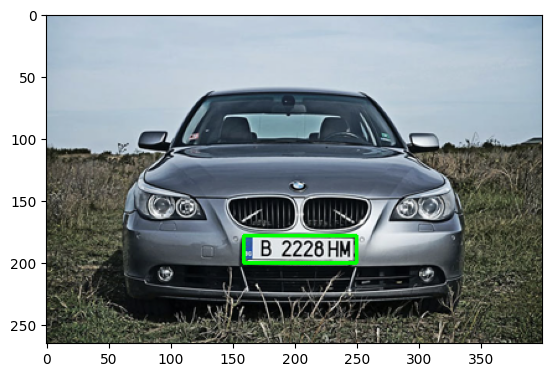

In [45]:
file_path = image_path[250]
print(file_path)
img = cv2.imread(file_path)
print(df['xmax'][250],df['xmin'][250],df['ymax'][250],df['ymin'][250])
cv2.rectangle(img, (df['xmin'][250],df['ymin'][250]), (df['xmax'][250],df['ymax'][250]), (0, 255, 0), 2)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img) 

In [46]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard

In [47]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values # drop the first column filepath
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing, resizing and normalization
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels (xmin,xmax,ymin,ymax) / (w,w,h,h)
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [48]:
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [49]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((526, 224, 224, 3), (132, 224, 224, 3), (526, 4), (132, 4))

In [50]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

In [51]:
# Complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [52]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=180,
                    validation_data=(x_test,y_test),callbacks=[tfb])


Epoch 1/180
53/53 [==============================] - 18s 96ms/step - loss: 0.0294 - val_loss: 0.0157
Epoch 2/180
53/53 [==============================] - 3s 64ms/step - loss: 0.0080 - val_loss: 0.0126
Epoch 3/180
53/53 [==============================] - 3s 63ms/step - loss: 0.0050 - val_loss: 0.0087
Epoch 4/180
53/53 [==============================] - 3s 64ms/step - loss: 0.0043 - val_loss: 0.0090
Epoch 5/180
53/53 [==============================] - 3s 64ms/step - loss: 0.0030 - val_loss: 0.0082
Epoch 6/180
53/53 [==============================] - 3s 64ms/step - loss: 0.0024 - val_loss: 0.0086
Epoch 7/180
53/53 [==============================] - 3s 64ms/step - loss: 0.0021 - val_loss: 0.0085
Epoch 8/180
53/53 [==============================] - 3s 64ms/step - loss: 0.0018 - val_loss: 0.0086
Epoch 9/180
53/53 [==============================] - 3s 65ms/step - loss: 0.0017 - val_loss: 0.0087
Epoch 10/180
53/53 [==============================] - 3s 64ms/step - loss: 0.0017 - val_loss: 0.008

In [53]:
model.save('./models/object_detection.h5')

1/1 [==============================] - 1s 1s/step
(333, 482) (575, 539)


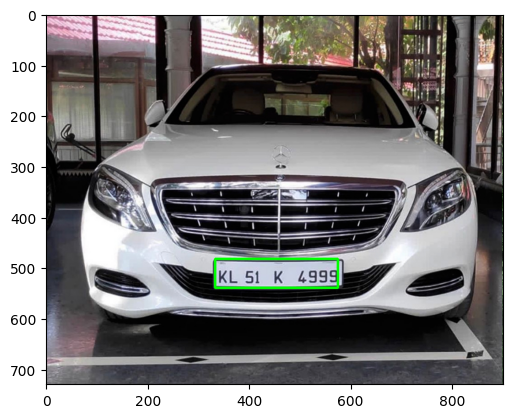

In [54]:
path = './data/number-plate-detection/TEST/TEST.jpeg'

def object_detection(path):
    
    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    
    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # Make predictions
    coords = model.predict(test_arr)
    
    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image,coords = object_detection(path)
plt.imshow(image)